# MODULES IMPORT

In [7]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #pandas used for data manipulation and analysis.
                 
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path

import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors

----------------
## Proto

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from pathlib import Path
from os.path import join 

In [9]:
def load_data(path):
    tasks = []
    for file_path in os.listdir(path):
        task_file = join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [10]:
path = Path("./data")
train_tasks = load_data(path / 'training')
evaluation_tasks = load_data(path /'evaluation')
test_tasks = load_data(path / 'test')

In [11]:
def max_padding(x):
    x = torch.Tensor(x)
    return nn.ConstantPad2d((floor((30 - x.shape[1])/2), floor((30 - x.shape[2])/2),
                                       ceil((30 - x.shape[2])/2), ceil((30 - x.shape[1])/2)), 0)(x)
    

In [18]:
class ArcData(Dataset):

    def __init__(self, Xy, type_ = "train"):
        
        self.Xy = Xy
        self.type = type_
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        Xy = self.Xy[idx][self.type]
        X = [x["input"] for x in Xy]
        if self.type == "train":
            y = [y["output"] for y in Xy]
        
        return np.array(X), np.array(y)


In [16]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(10, 10, 5, padding = 2)

    def forward(self, x):

        x =self.conv1(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [19]:
def expand(x):
    if len(x.shape) != 2:
        x = np.expand_dims(x, 1)
    return x

def pad(x):
    x = np.array([i for i in x])
    img = np.array([np.zeros((x.shape[0], x.shape[1]))+i for i in range(10)])
    img = (x-img == 0)*1
    return img

NUM_EPOCHS = 10

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")
net = Net()
criterion = nn.MSELoss()
optimizer = Adam(net.parameters(), lr = 0.01)
training_set = ArcData(train_tasks)
history = []
for batch in training_set:
    X, Y = batch
    for epoch in range(NUM_EPOCHS):
        for x,y in zip(X,Y):
            try:
                x = expand(np.array(x))
                y = expand(np.array(y))

                if (x.shape == y.shape):
                    padded_x = pad(x)
                    padded_y = pad(y)
                    inputs = torch.Tensor(padded_x).unsqueeze(0)
                    outputs = torch.Tensor(padded_y).unsqueeze(0)
                    out = net(inputs)
                    loss = criterion(out, outputs)
                    history.append(loss)
                    loss.backward()
                    optimizer.step()
            except:
                continue
                

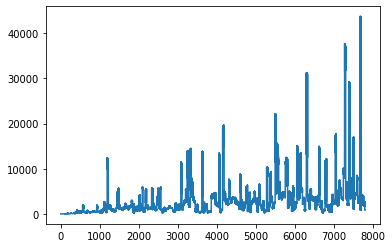

In [20]:
plt.plot(history)

In [ ]:
    if train:
        # Zero gradients
        model.train()
        optimiser.zero_grad()
    else:
        model.eval()

    # Embed all samples
    embeddings = model(x)

    # Samples are ordered by the NShotWrapper class as follows:
    # k lots of n support samples from a particular class
    # k lots of q query samples from those classes
    support = embeddings[:n_shot*k_way]
    queries = embeddings[n_shot*k_way:]
    prototypes = compute_prototypes(support, k_way, n_shot)

    # Calculate squared distances between all queries and all prototypes
    # Output should have shape (q_queries * k_way, k_way) = (num_queries, k_way)
    distances = pairwise_distances(queries, prototypes, distance)

    # Calculate log p_{phi} (y = k | x)
    log_p_y = (-distances).log_softmax(dim=1)
    loss = loss_fn(log_p_y, y)

    # Prediction probabilities are softmax over distances
    y_pred = (-distances).softmax(dim=1)

    if train:
        # Take gradient step
        loss.backward()
        optimiser.step()
    else:
        pass

    return loss, y_pred


def compute_prototypes(support: torch.Tensor, k: int, n: int) -> torch.Tensor:
    """Compute class prototypes from support samples.
    # Arguments
        support: torch.Tensor. Tensor of shape (n * k, d) where d is the embedding
            dimension.
        k: int. "k-way" i.e. number of classes in the classification task
        n: int. "n-shot" of the classification task
    # Returns
        class_prototypes: Prototypes aka mean embeddings for each class
    """
    # Reshape so the first dimension indexes by class then take the mean
    # along that dimension to generate the "prototypes" for each class
    class_prototypes = support.reshape(k, n, -1).mean(dim=1)
